# TUR-1149

In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/jovyan')
import util
import pandas as pd
pd.set_option('display.max_columns', None)

my_gs_path = 'gs://wx-lty-mmm-super-dev/data/dev/2021-09-20-tur-1149/ranking_yes'
predicted_df = util.pq2df(my_gs_path)
predicted_df.head()

IS_NEWLY_ONBOARDED_CUST  IS_PREV_DNS_HV    base_spd  camp_dur_wks  \
0                    False           False  132.798253           1.0   
1                    False           False  132.798253           3.0   
2                    False           False  132.798253           2.0   
3                    False           False  132.798253           1.0   
4                    False           False  132.798253           2.0   

  campaign_type          campaign_type_long                  crn  \
0           MP1     multiplier 1 week store  1000000000000001225   
1           SGU      spend get unlock store  1000000000000001225   
2           SS2  spend stretch 2 week store  1000000000000001225   
3           MP1     multiplier 1 week store  1000000000000001225   
4           SS2  spend stretch 2 week store  1000000000000001225   

   crn_offer_cnt     cvm  force_random  inc_sales  inc_sales_tot     l8w_spd  \
0           11.0  HVHIGH         False   6.700580       6.700580  202.587143   
1           11.0  HVHIGH         False -21.641354     -64.924061  202.587143   
2           11.0  HVHIGH         False -12.602125     -25.204250  202.587143   
3           11.0  HVHIGH         False   6.700580       6.700580  202.587143   
4           11.0  HVHIGH         False -12.602125     -25.204250  202.587143   

                   offer_type open_an_email_or_activate_offer_26wk     p_rdm  \
0     multiplier 1 week store                                    Y  0.003526   
1      spend get unlock store                                    Y  0.000899   
2  spend stretch 2 week store                                    Y  0.000840   
3     multiplier 1 week store                                    Y  0.003108   
4  spend stretch 2 week store                                    Y  0.000896   

   random_allocation  ranking  rdm_inc_sales  rdm_inc_sales_tot     reward  \
0              False     True       0.023628           0.023628  10.129357   
1              False     True      -0.019462          -0.058387  73.500000   
2              False     True      -0.010586          -0.021172  16.000000   
3              False     True       0.020822           0.020822   3.038807   
4              False     True      -0.011295          -0.022590  16.000000   

   sample_ratio      score selection  spd|not_rdm     spd|rdm  target_cost  \
0           0.1   6.700580     model   139.498833  139.498833     0.035718   
1           0.1 -21.641354     model   111.156899  111.156899     0.066099   
2           0.1 -12.602125     model   120.196128  120.196128     0.013440   
3           0.1   6.700580     model   139.498833  139.498833     0.009443   
4           0.1 -12.602125     model   120.196128  120.196128     0.014340   

   target_spd           template_id     uuid  is_dns_forced_offer  
0  139.498833   CVM-3509_20210927_4  71347.0                    0  
1  111.156899  CVM-3529_20210927_59  71350.0                    0  
2  120.196128  CVM-0007_20210927_49  71341.0                    0  
3  139.498833   CVM-3509_20210927_2  71345.0                    0  
4  120.196128  CVM-0007_20210927_21  71340.0                    0

In [2]:
predicted_df = predicted_df[['crn', 'campaign_type', 'template_id', 'score', 'base_spd', 'target_cost']]
predicted_df['inc_sales'] = predicted_df['score'] - predicted_df['target_cost']

In [3]:
sql = '''
    SELECT *
    FROM `wx-bq-poc.personal.dhioe_tur1149`
'''
inactive_df = util.sql2df('wx-bq-poc', sql)

In [4]:
predicted_inactive_df = inactive_df.merge(
    predicted_df, left_on='crn', right_on='crn'
)[['crn', 'campaign_type', 'template_id', 'score', 'base_spd', 'target_cost']]
predicted_inactive_df['inc_sales'] = predicted_inactive_df['score'] - predicted_inactive_df['target_cost']

In [5]:
agg_predicted_df = predicted_df.groupby('crn').aggregate({'inc_sales': 'max'}).reset_index()
agg_predicted_df = predicted_df.merge(agg_predicted_df, left_on=['crn','inc_sales'], right_on=['crn','inc_sales'])
agg_predicted_df = agg_predicted_df.groupby('campaign_type').aggregate({'crn':'count'}).reset_index()

In [6]:
agg_predicted_inactive_df = predicted_inactive_df.groupby('crn').aggregate({'inc_sales': 'max'}).reset_index()
agg_predicted_inactive_df = predicted_inactive_df.merge(agg_predicted_inactive_df, left_on=['crn','inc_sales'], right_on=['crn','inc_sales'])
agg_predicted_inactive_df = agg_predicted_inactive_df.groupby('campaign_type').aggregate({'crn':'count'}).reset_index()

In [8]:
df =  agg_predicted_inactive_df.merge(agg_predicted_df, left_on=['campaign_type'], right_on=['campaign_type'])
df['p_inactive'] = df['crn_x'] / df['crn_y']

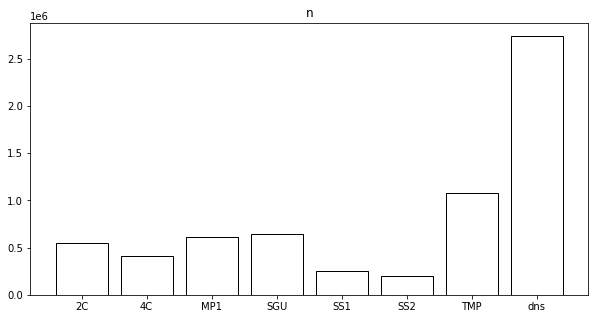

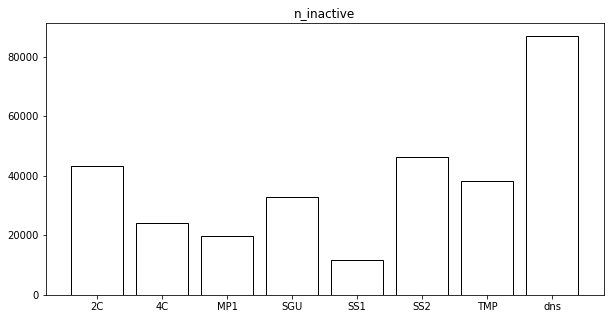

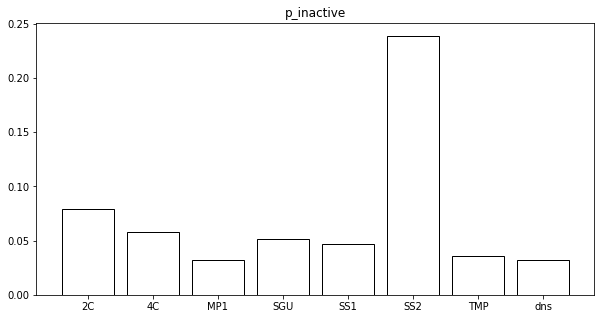

In [9]:
plt.figure(figsize=(10,5))
plt.title('n')
plt.bar(agg_predicted_df['campaign_type'], agg_predicted_df['crn'], fill=False)
plt.show()

plt.figure(figsize=(10,5))
plt.title('n_inactive')
plt.bar(agg_predicted_inactive_df['campaign_type'], agg_predicted_inactive_df['crn'], fill=False)
plt.show()

plt.figure(figsize=(10,5))
plt.title('p_inactive')
plt.bar(df['campaign_type'], df['p_inactive'], fill=False)
plt.show()

In [10]:
MAPPING = {
    'CVM-0056':'RA',
    'CVM-0007':'SS2',
    'CVM-3529':'SGU',
    'CVM-3525':'SS1',
    'CVM-0108':'4C',
    'CVM-0106':'2C',
    'CVM-4310':'TMP',
    'CVM-3509':'MP',
}

In [11]:
sql = '''
    SELECT crn, campaign_code
    FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_AUDIENCE_MASTER`
    WHERE partition_date = '2021-09-20'
'''
pred_selected_df = util.sql2df('gcp-wow-rwds-ai-mmm-super-dev', sql)
pred_selected_df['campaign_type'] = pred_selected_df['campaign_code'].apply(lambda x: MAPPING[x])
agg_pred_selected_df = pred_selected_df.groupby('campaign_type').aggregate({'crn': 'count'}).reset_index()

In [12]:
pred_selected_inactive_df = pred_selected_df.merge(inactive_df, left_on='crn', right_on='crn')
agg_pred_selected_inactive_df = pred_selected_inactive_df.groupby('campaign_type').aggregate({'crn': 'count'}).reset_index()

In [13]:
df = agg_pred_selected_inactive_df.merge(agg_pred_selected_df, left_on=['campaign_type'], right_on=['campaign_type'])
df['p_inactive'] = df['crn_x'] / df['crn_y']

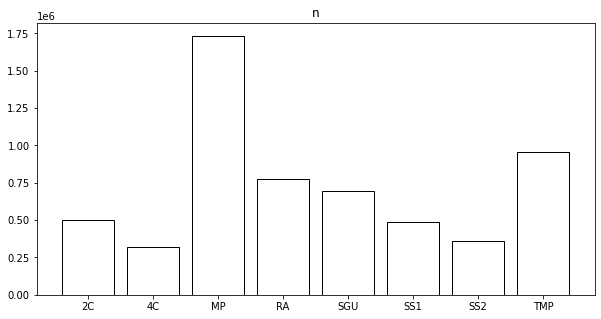

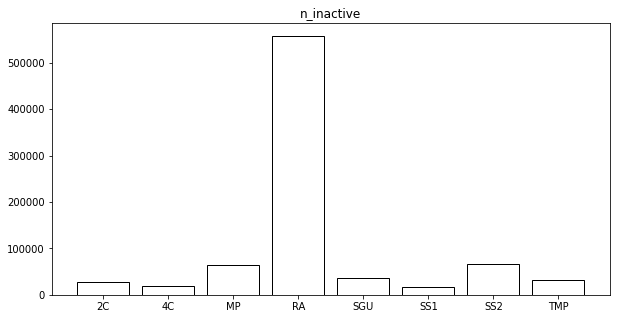

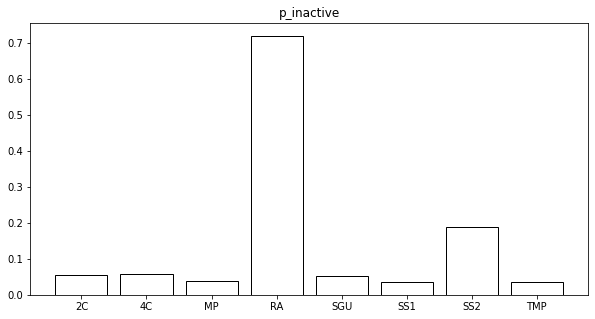

In [14]:
plt.figure(figsize=(10,5))
plt.title('n')
plt.bar(agg_pred_selected_df['campaign_type'], agg_pred_selected_df['crn'], fill=False)
plt.show()

plt.figure(figsize=(10,5))
plt.title('n_inactive')
plt.bar(agg_pred_selected_inactive_df['campaign_type'], agg_pred_selected_inactive_df['crn'], fill=False)
plt.show()

plt.figure(figsize=(10,5))
plt.title('p_inactive')
plt.bar(df['campaign_type'], df['p_inactive'], fill=False)
plt.show()